In [60]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

import warnings
warnings.filterwarnings('ignore')  

In [61]:
all_classes = ["notumor", "glioma", "meningioma", "pituitary"]

In [62]:
class datasetCreation(torch.utils.data.Dataset):
    def __init__(self, imageDir: str, transform : torchvision.transforms.Compose, all_classes: list):
        def get_image(individual_class):
            images = os.listdir(os.path.join(imageDir, individual_class))
            return images
        
        self.images_dict = {}
        self.transform = transform
        self.all_classes = all_classes
        self.imageDir = imageDir
        
        for i in self.all_classes:
            self.images_dict[i] = get_image(i)
        
        print(self.images_dict)
        
    def __len__(self):
        return sum([len(self.images_dict[i]) for i in self.all_classes])
    
    def __getitem__(self, idx):
        individual_class = random.choice(self.all_classes)
        idx = idx % len(self.images_dict[individual_class]) # To keep the index inside the length of the list of images in individual class
        imagename = self.images_dict[individual_class][idx]
        imagepath = os.path.join(self.imageDir, individual_class, imagename)
        image = Image.open(imagepath).convert('RGB')
        return self.transform(image), self.all_classes.index(individual_class)

In [63]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [64]:
trainDataset = datasetCreation(os.path.join("Dataset", "Training"), train_transform, all_classes)
testDataset = datasetCreation(os.path.join("Dataset", "Testing"), test_transform, all_classes)

{'notumor': ['Tr-noTr_0000.jpg', 'Tr-noTr_0001.jpg', 'Tr-noTr_0002.jpg', 'Tr-noTr_0003.jpg', 'Tr-noTr_0004.jpg', 'Tr-noTr_0005.jpg', 'Tr-noTr_0006.jpg', 'Tr-noTr_0007.jpg', 'Tr-noTr_0008.jpg', 'Tr-noTr_0009.jpg', 'Tr-no_0010.jpg', 'Tr-no_0011.jpg', 'Tr-no_0012.jpg', 'Tr-no_0013.jpg', 'Tr-no_0014.jpg', 'Tr-no_0015.jpg', 'Tr-no_0016.jpg', 'Tr-no_0017.jpg', 'Tr-no_0018.jpg', 'Tr-no_0019.jpg', 'Tr-no_0020.jpg', 'Tr-no_0021.jpg', 'Tr-no_0022.jpg', 'Tr-no_0023.jpg', 'Tr-no_0024.jpg', 'Tr-no_0025.jpg', 'Tr-no_0026.jpg', 'Tr-no_0027.jpg', 'Tr-no_0028.jpg', 'Tr-no_0029.jpg', 'Tr-no_0030.jpg', 'Tr-no_0031.jpg', 'Tr-no_0032.jpg', 'Tr-no_0033.jpg', 'Tr-no_0034.jpg', 'Tr-no_0035.jpg', 'Tr-no_0036.jpg', 'Tr-no_0037.jpg', 'Tr-no_0038.jpg', 'Tr-no_0039.jpg', 'Tr-no_0040.jpg', 'Tr-no_0041.jpg', 'Tr-no_0042.jpg', 'Tr-no_0043.jpg', 'Tr-no_0044.jpg', 'Tr-no_0045.jpg', 'Tr-no_0046.jpg', 'Tr-no_0047.jpg', 'Tr-no_0048.jpg', 'Tr-no_0049.jpg', 'Tr-no_0050.jpg', 'Tr-no_0051.jpg', 'Tr-no_0052.jpg', 'Tr-no_0053.j

In [65]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(testDataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 952
Number of test batches 219


In [66]:
images, labels = next(iter(dl_train))

In [67]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [68]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [ ]:
def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{all_classes[int(labels[i].numpy())]}')
        plt.ylabel(f'{all_classes[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

In [72]:
def show_preds():
    resnet18.eval() # set to evaluation mode
    images, labels = next(iter(dl_test))
    # print(images, labels)
    outputs = resnet18(images) 
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

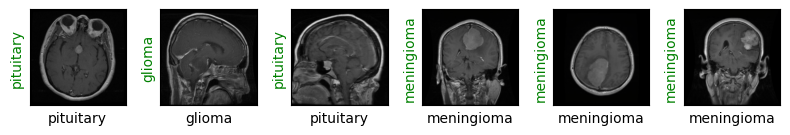

In [82]:
show_preds()

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(testDataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.98:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/20
Evaluating at step 0
Validation Loss: 1.4279, Accuracy: 0.2548


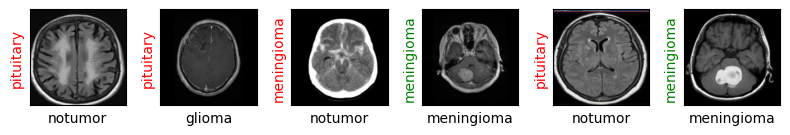

Evaluating at step 20
Validation Loss: 1.0281, Accuracy: 0.5843


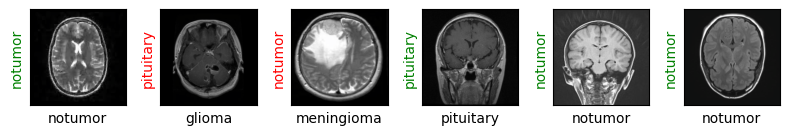

Evaluating at step 40
Validation Loss: 0.7803, Accuracy: 0.7132


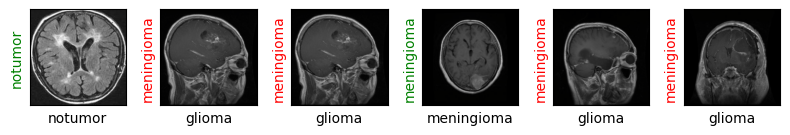

Evaluating at step 60
Validation Loss: 0.6021, Accuracy: 0.8017


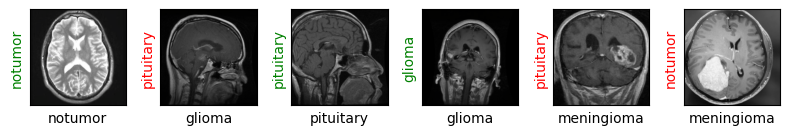

Evaluating at step 80
Validation Loss: 0.5453, Accuracy: 0.8101


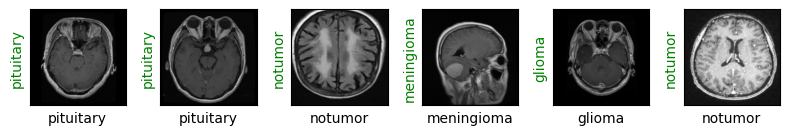

Evaluating at step 100
Validation Loss: 0.5473, Accuracy: 0.8215


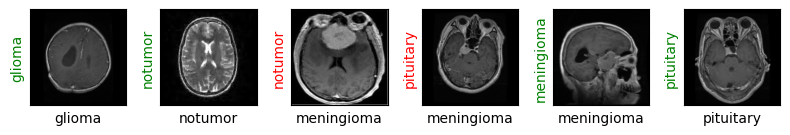

Evaluating at step 120
Validation Loss: 0.4654, Accuracy: 0.8345


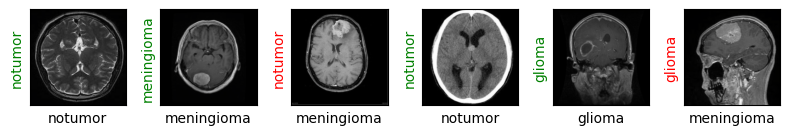

Evaluating at step 140
Validation Loss: 0.4430, Accuracy: 0.8444


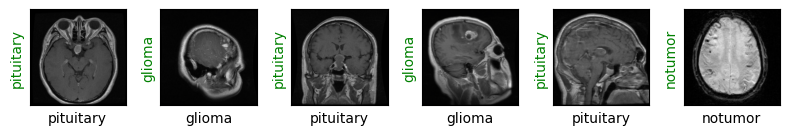

Evaluating at step 160
Validation Loss: 0.3981, Accuracy: 0.8604


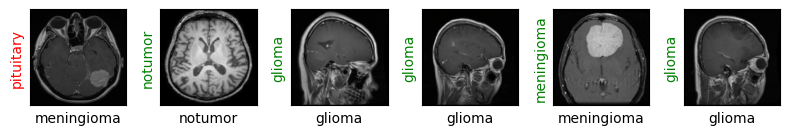

Evaluating at step 180
Validation Loss: 0.4157, Accuracy: 0.8612


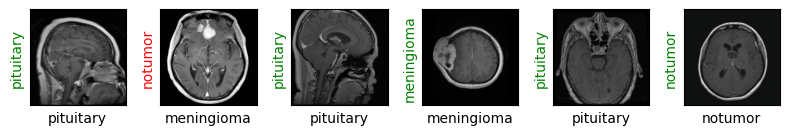

Evaluating at step 200
Validation Loss: 0.3999, Accuracy: 0.8596


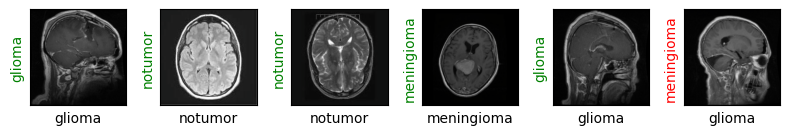

Evaluating at step 220
Validation Loss: 0.3261, Accuracy: 0.8749


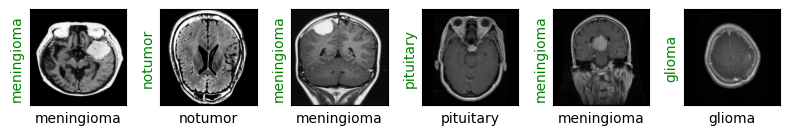

Evaluating at step 240
Validation Loss: 0.3413, Accuracy: 0.8688


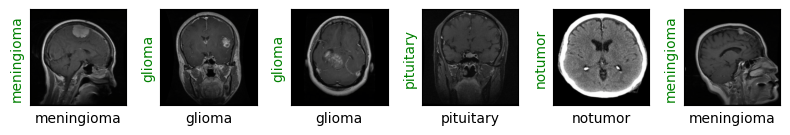

Evaluating at step 260
Validation Loss: 0.3439, Accuracy: 0.8589


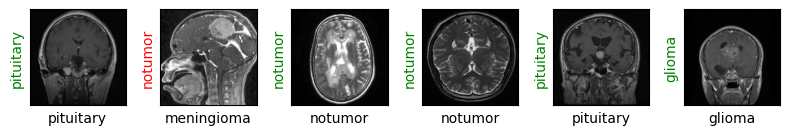

Evaluating at step 280
Validation Loss: 0.2593, Accuracy: 0.9024


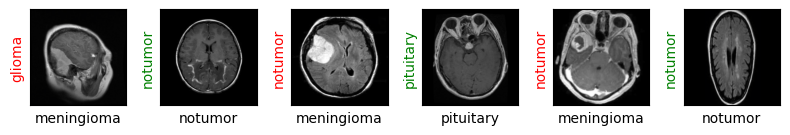

Evaluating at step 300
Validation Loss: 0.2295, Accuracy: 0.9130


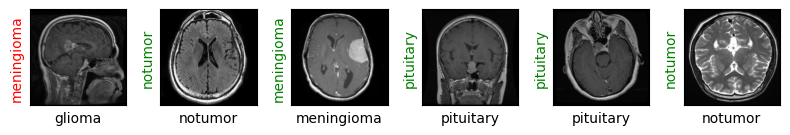

Evaluating at step 320
Validation Loss: 0.2404, Accuracy: 0.9130


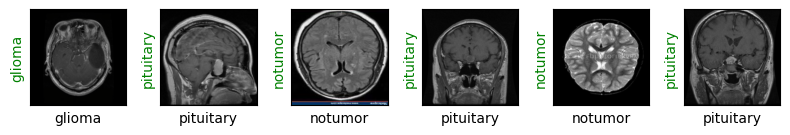

Evaluating at step 340
Validation Loss: 0.2078, Accuracy: 0.9344


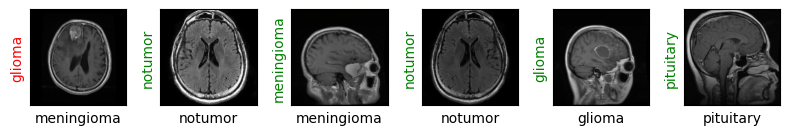

Evaluating at step 360
Validation Loss: 0.2359, Accuracy: 0.9054


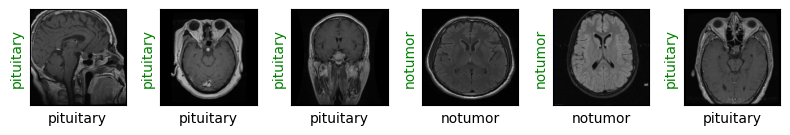

Evaluating at step 380
Validation Loss: 0.2499, Accuracy: 0.9024


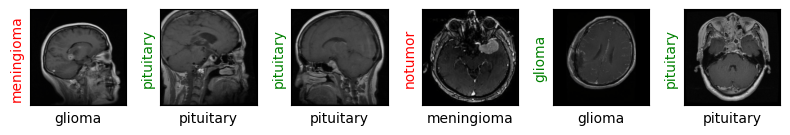

Evaluating at step 400
Validation Loss: 0.2365, Accuracy: 0.9130


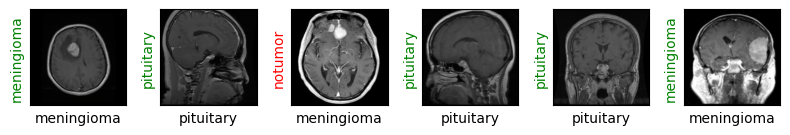

Evaluating at step 420
Validation Loss: 0.1732, Accuracy: 0.9413


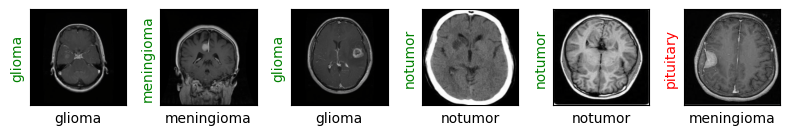

Evaluating at step 440
Validation Loss: 0.1995, Accuracy: 0.9314


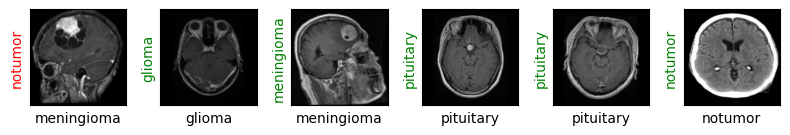

Evaluating at step 460
Validation Loss: 0.1842, Accuracy: 0.9336


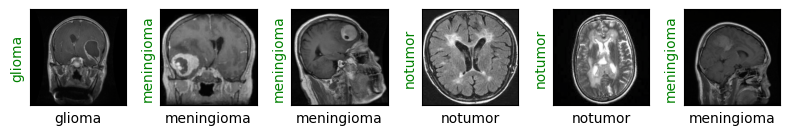

Evaluating at step 480
Validation Loss: 0.2182, Accuracy: 0.9184


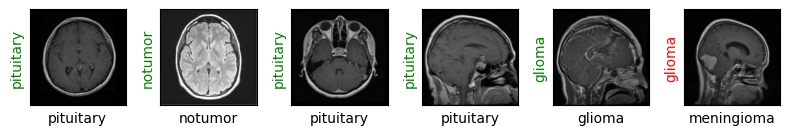

Evaluating at step 500
Validation Loss: 0.2070, Accuracy: 0.9382


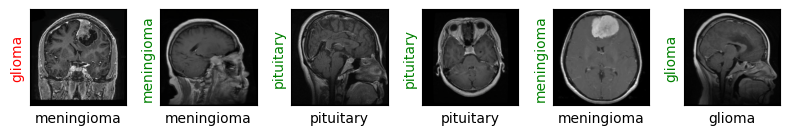

Evaluating at step 520
Validation Loss: 0.2334, Accuracy: 0.9245


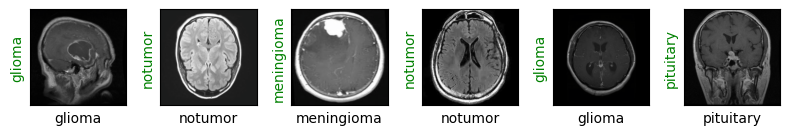

Evaluating at step 540
Validation Loss: 0.2117, Accuracy: 0.9405


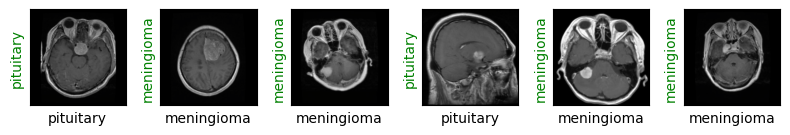

Evaluating at step 560
Validation Loss: 0.2226, Accuracy: 0.9298


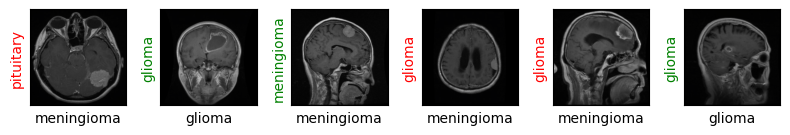

Evaluating at step 580
Validation Loss: 0.1813, Accuracy: 0.9359


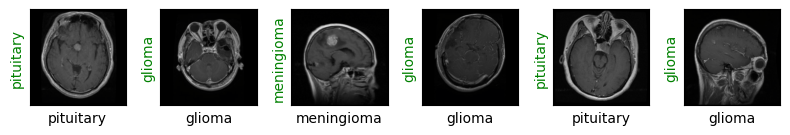

Evaluating at step 600
Validation Loss: 0.1387, Accuracy: 0.9458


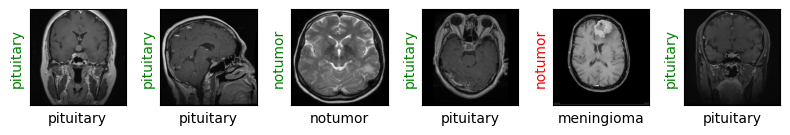

Evaluating at step 620
Validation Loss: 0.1752, Accuracy: 0.9321


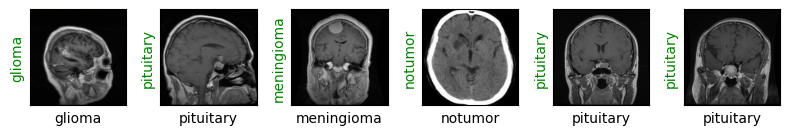

Evaluating at step 640
Validation Loss: 0.1570, Accuracy: 0.9535


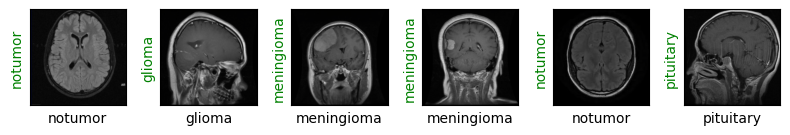

Evaluating at step 660
Validation Loss: 0.1335, Accuracy: 0.9565


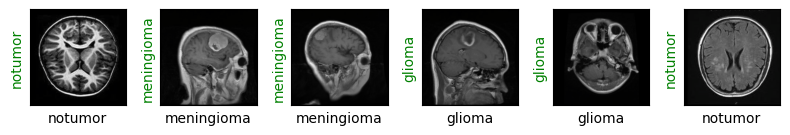

Evaluating at step 680
Validation Loss: 0.1383, Accuracy: 0.9550


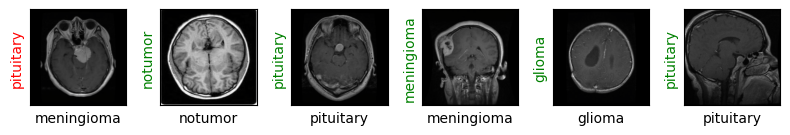

Evaluating at step 700
Validation Loss: 0.1856, Accuracy: 0.9306


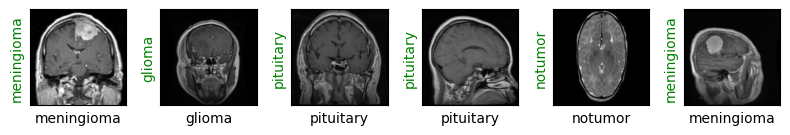

Evaluating at step 720
Validation Loss: 0.1777, Accuracy: 0.9298


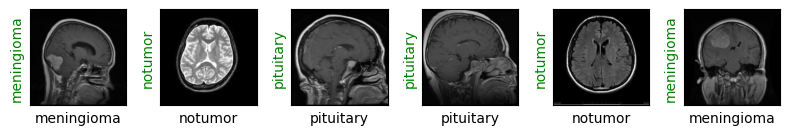

Evaluating at step 740
Validation Loss: 0.1896, Accuracy: 0.9367


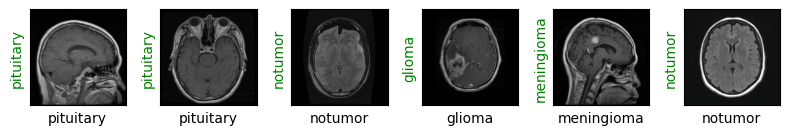

Evaluating at step 760
Validation Loss: 0.1808, Accuracy: 0.9283


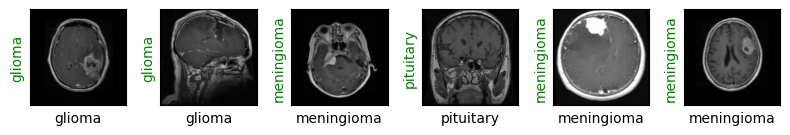

Evaluating at step 780
Validation Loss: 0.2156, Accuracy: 0.9275


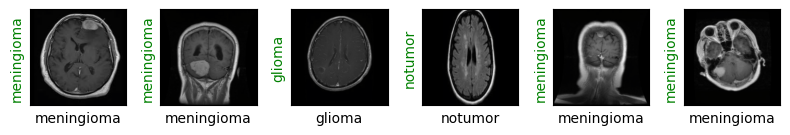

Evaluating at step 800
Validation Loss: 0.1483, Accuracy: 0.9420


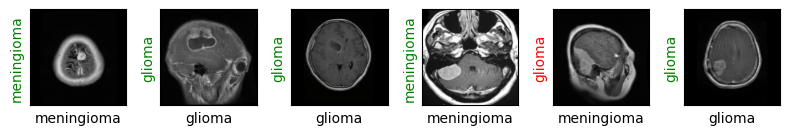

Evaluating at step 820
Validation Loss: 0.1272, Accuracy: 0.9550


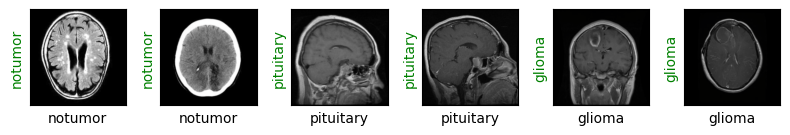

Evaluating at step 840
Validation Loss: 0.1372, Accuracy: 0.9436


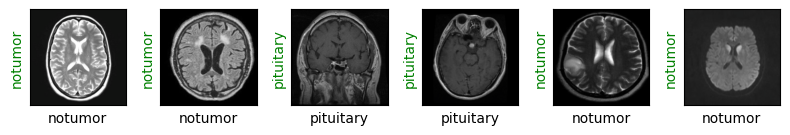

Evaluating at step 860
Validation Loss: 0.1821, Accuracy: 0.9367


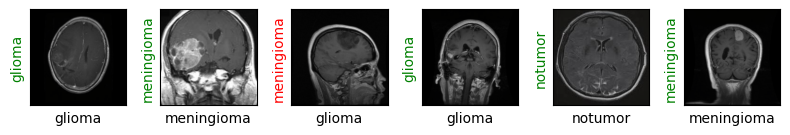

Evaluating at step 880
Validation Loss: 0.1630, Accuracy: 0.9489


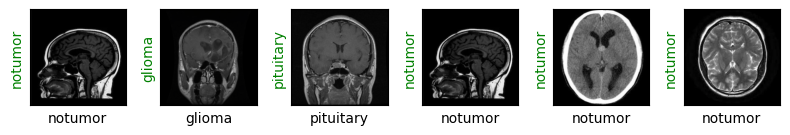

Evaluating at step 900
Validation Loss: 0.1630, Accuracy: 0.9497


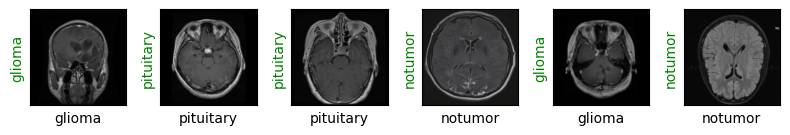

Evaluating at step 920
Validation Loss: 0.1226, Accuracy: 0.9573


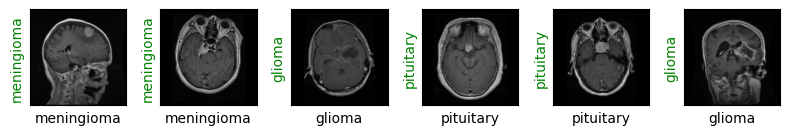

Evaluating at step 940
Validation Loss: 0.1053, Accuracy: 0.9718


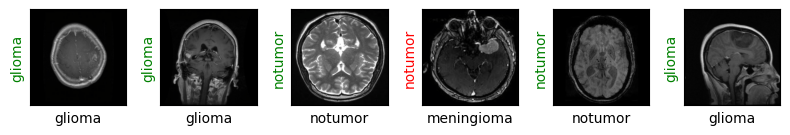

Training Loss: 0.3377
Starting epoch 2/20
Evaluating at step 0
Validation Loss: 0.1202, Accuracy: 0.9649


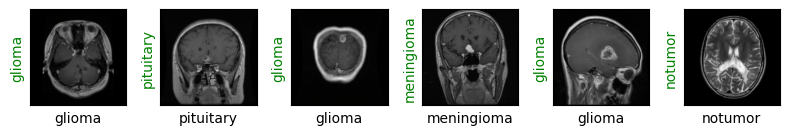

Evaluating at step 20
Validation Loss: 0.1649, Accuracy: 0.9451


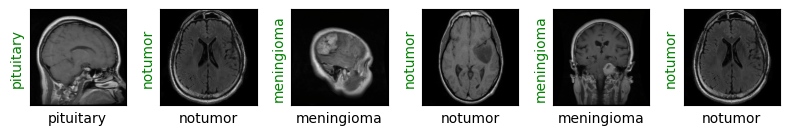

Evaluating at step 40
Validation Loss: 0.1099, Accuracy: 0.9596


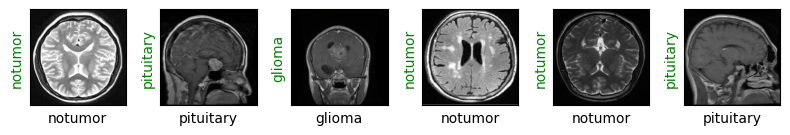

Evaluating at step 60
Validation Loss: 0.1089, Accuracy: 0.9603


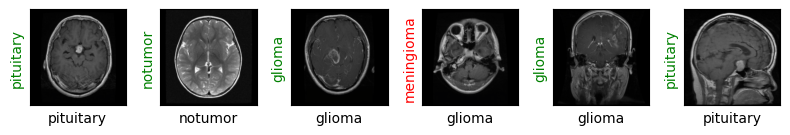

Evaluating at step 80
Validation Loss: 0.1254, Accuracy: 0.9603


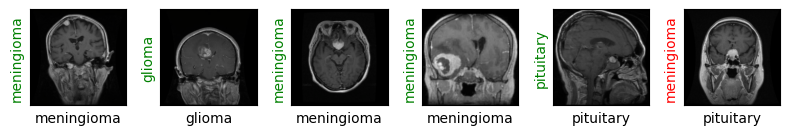

Evaluating at step 100
Validation Loss: 0.1110, Accuracy: 0.9535


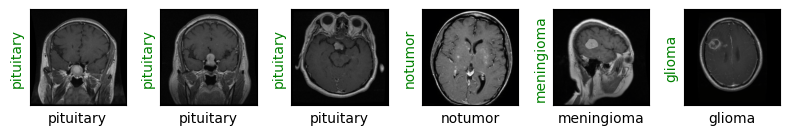

Evaluating at step 120
Validation Loss: 0.1138, Accuracy: 0.9634


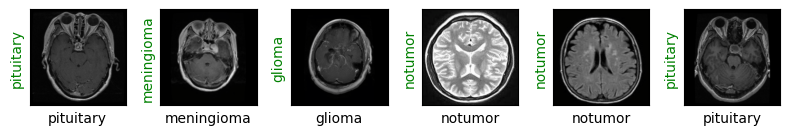

Evaluating at step 140
Validation Loss: 0.1599, Accuracy: 0.9466


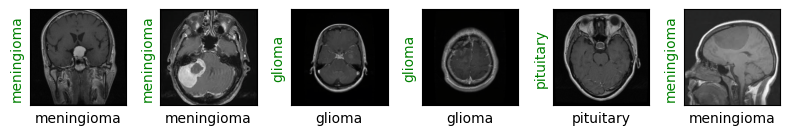

Evaluating at step 160
Validation Loss: 0.1283, Accuracy: 0.9527


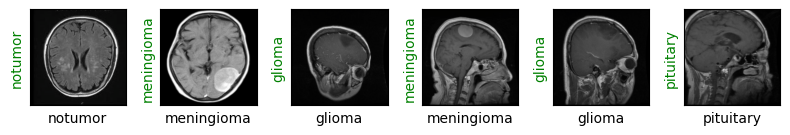

Evaluating at step 180
Validation Loss: 0.1101, Accuracy: 0.9603


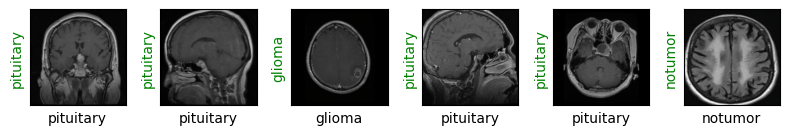

Evaluating at step 200
Validation Loss: 0.0766, Accuracy: 0.9779


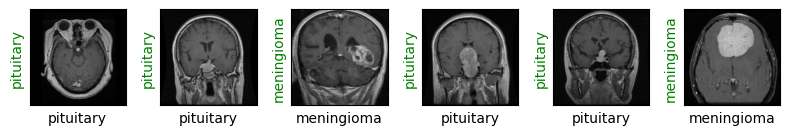

Evaluating at step 220
Validation Loss: 0.0921, Accuracy: 0.9703


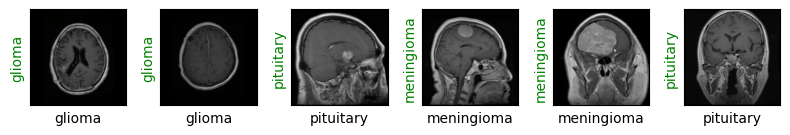

Evaluating at step 240
Validation Loss: 0.0983, Accuracy: 0.9725


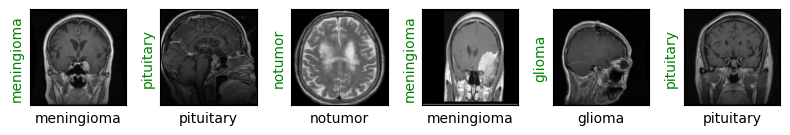

Evaluating at step 260
Validation Loss: 0.1537, Accuracy: 0.9504


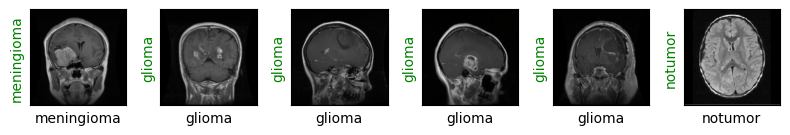

Evaluating at step 280
Validation Loss: 0.0884, Accuracy: 0.9657


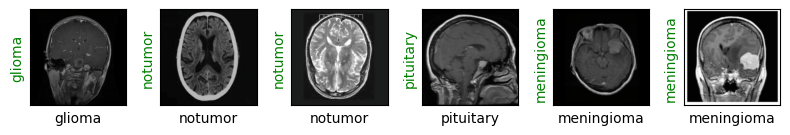

Evaluating at step 300
Validation Loss: 0.0860, Accuracy: 0.9741


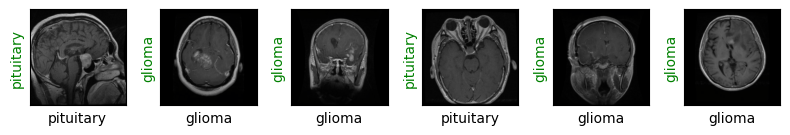

Evaluating at step 320
Validation Loss: 0.1069, Accuracy: 0.9641


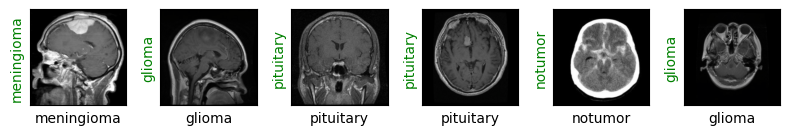

Evaluating at step 340
Validation Loss: 0.0955, Accuracy: 0.9672


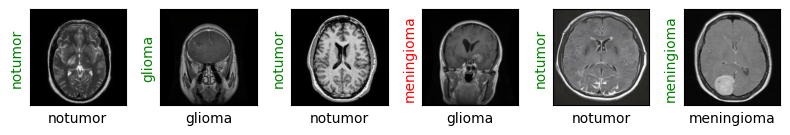

Evaluating at step 360
Validation Loss: 0.0864, Accuracy: 0.9718


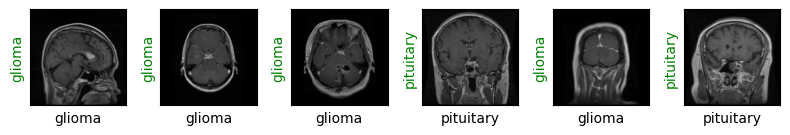

Evaluating at step 380
Validation Loss: 0.0939, Accuracy: 0.9603


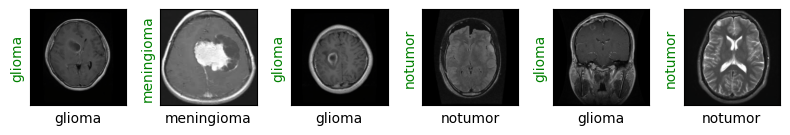

Evaluating at step 400
Validation Loss: 0.1006, Accuracy: 0.9657


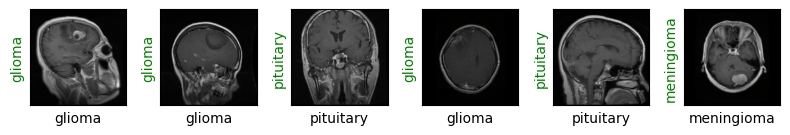

Evaluating at step 420
Validation Loss: 0.0962, Accuracy: 0.9664


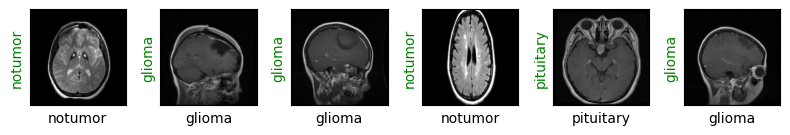

Evaluating at step 440
Validation Loss: 0.1013, Accuracy: 0.9680


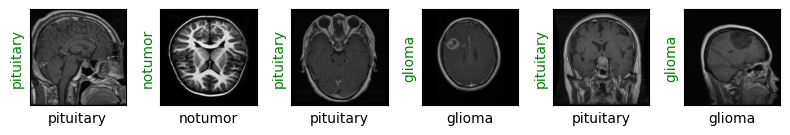

Evaluating at step 460
Validation Loss: 0.0715, Accuracy: 0.9756


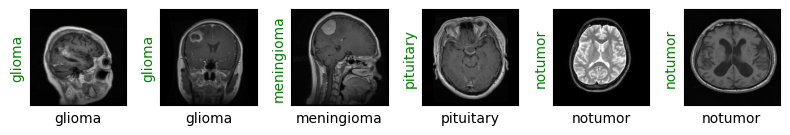

Evaluating at step 480
Validation Loss: 0.0710, Accuracy: 0.9733


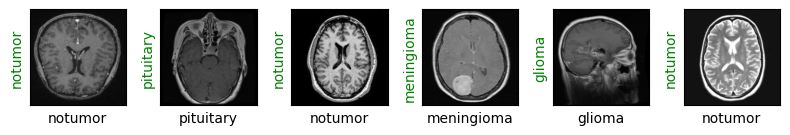

Evaluating at step 500
Validation Loss: 0.0765, Accuracy: 0.9703


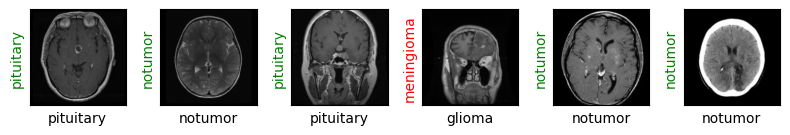

Evaluating at step 520
Validation Loss: 0.0774, Accuracy: 0.9741


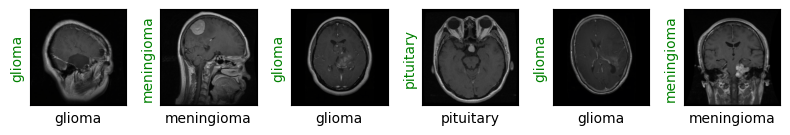

Evaluating at step 540
Validation Loss: 0.0953, Accuracy: 0.9664


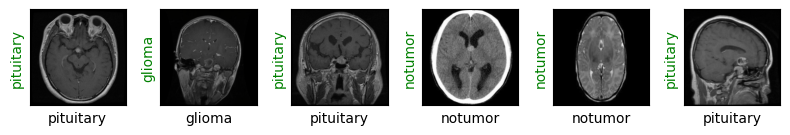

Evaluating at step 560
Validation Loss: 0.0754, Accuracy: 0.9741


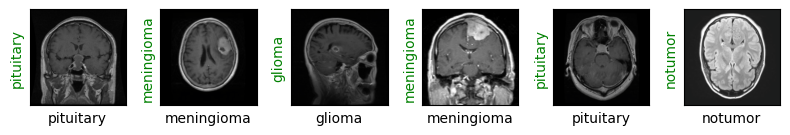

Evaluating at step 580
Validation Loss: 0.0979, Accuracy: 0.9657


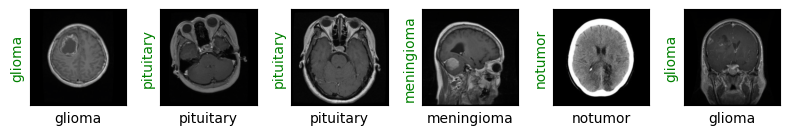

Evaluating at step 600
Validation Loss: 0.0730, Accuracy: 0.9771


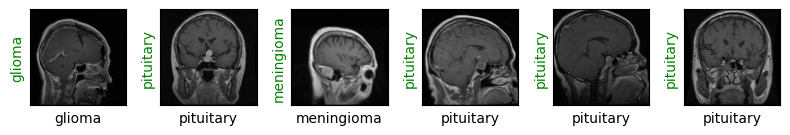

Evaluating at step 620
Validation Loss: 0.0880, Accuracy: 0.9756


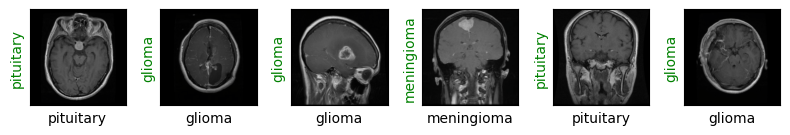

Evaluating at step 640
Validation Loss: 0.1297, Accuracy: 0.9573


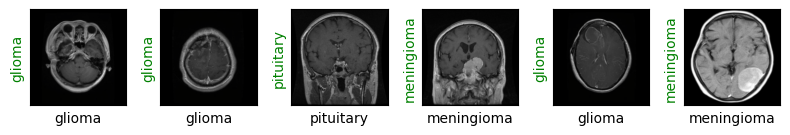

Evaluating at step 660
Validation Loss: 0.0803, Accuracy: 0.9786


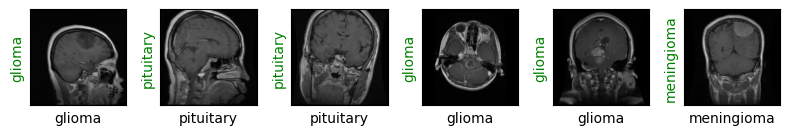

Evaluating at step 680
Validation Loss: 0.0818, Accuracy: 0.9756


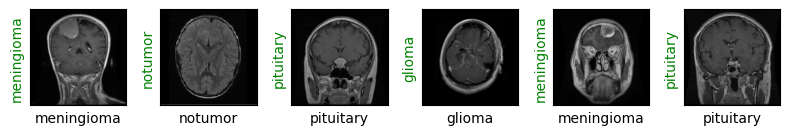

Evaluating at step 700
Validation Loss: 0.0976, Accuracy: 0.9695


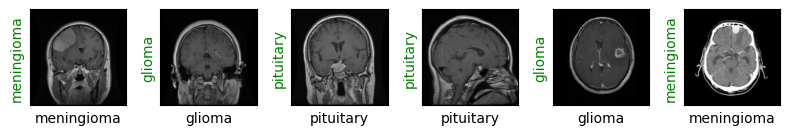

Evaluating at step 720
Validation Loss: 0.0846, Accuracy: 0.9748


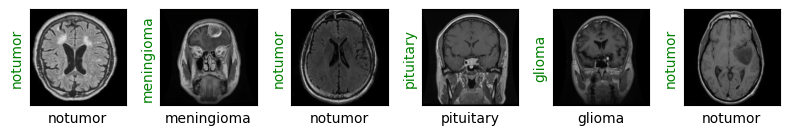

Evaluating at step 740
Validation Loss: 0.1136, Accuracy: 0.9672


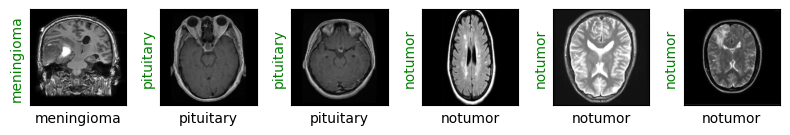

Evaluating at step 760
Validation Loss: 0.1175, Accuracy: 0.9626


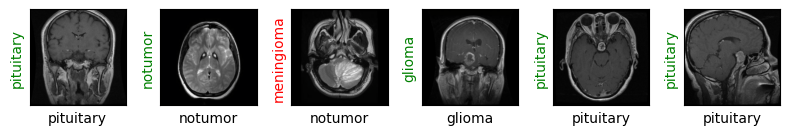

Evaluating at step 780
Validation Loss: 0.0892, Accuracy: 0.9756


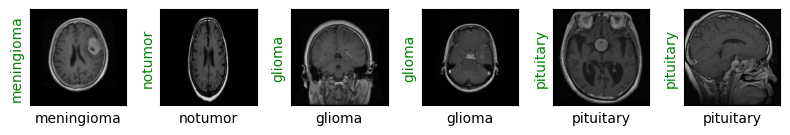

Evaluating at step 800
Validation Loss: 0.0552, Accuracy: 0.9817


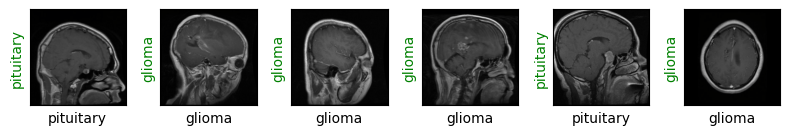

Performance condition satisfied, stopping..


In [79]:
train(epochs=20)

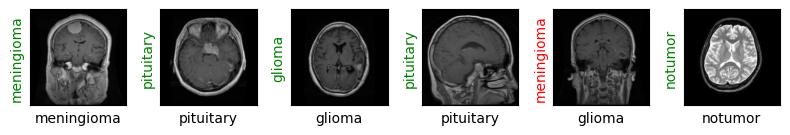

In [ ]:
show_preds()

In [95]:
resnet18.eval()
random_input = torch.randn(1,3,224,224)
onnx_output_path = "brainModel.onnx"
torch.onnx.export(
    resnet18,
    random_input,
    onnx_output_path,
    export_params=True,        # Store the trained parameter weights inside the model file
              # Specify the ONNX version
    do_constant_folding=True,  # Simplify the model by folding constant nodes
    input_names=['input'],     # Define input layer name
    output_names=['output']    # Define output layer name
)